# 05. Ensemble Stacking 실험

## 목표
- 여러 Base Model의 예측을 결합하여 성능 향상
- 2-Layer Stacking Architecture 구현
- Base Model 다양성으로 예측 안정성 확보

## 핵심 개념
- **Base Models**: 다양한 알고리즘으로 1차 예측 생성
- **Meta-Learner**: Base Model 예측을 입력으로 최종 예측
- **Out-of-Fold Prediction**: Train 데이터 과적합 방지를 위한 CV 기반 Stacking

## Stacking Architecture
```
Layer 1 (Base Models):     Layer 2 (Meta-Learner):
┌─────────────┐
│  CatBoost   │────┐
└─────────────┘    │
┌─────────────┐    │       ┌─────────────────┐
│  LightGBM   │────┼──────▶│ LogisticRegression │──▶ 최종 예측
└─────────────┘    │       └─────────────────┘
┌─────────────┐    │
│   XGBoost   │────┘
└─────────────┘
```

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import sys
sys.path.append('../features')
sys.path.append('../utils')
from feature_engineering import build_a_features, build_b_features
from preprocessing import FeaturePreprocessor
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 데이터 준비

In [13]:
# 데이터 로드 및 피처 생성
print("데이터 로드 및 피처 생성 중...")
train = pd.read_csv('../data/train.csv')
train_a = pd.read_csv('../data/train/A.csv')
train_b = pd.read_csv('../data/train/B.csv')

a_features = build_a_features(train_a)
b_features = build_b_features(train_b)

train_features = pd.concat([
    train[train['Test'] == 'A'].merge(a_features, on='Test_id', how='left'),
    train[train['Test'] == 'B'].merge(b_features, on='Test_id', how='left')
], ignore_index=True)

X = train_features.drop(['Test_id', 'Test', 'Label'], axis=1, errors='ignore')
y = train_features['Label']

X = X.select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)

preprocessor = FeaturePreprocessor()
X = preprocessor.fit_transform(X)

print(f"전처리 후 shape: {X.shape}")
print(f"Target 분포: 양성={y.sum()} ({y.mean():.2%})")

데이터 로드 및 피처 생성 중...
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=566.0s
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=566.0s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=162.7s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=162.7s
전처리: 51개 컬럼 제거 (유효값 부족 또는 상수), 217개 유지
전처리: 51개 컬럼 제거 (유효값 부족 또는 상수), 217개 유지
전처리 후 shape: (944767, 217)
Target 분포: 양성=27282 (2.89%)
전처리 후 shape: (944767, 217)
Target 분포: 양성=27282 (2.89%)


## 2. Base Models 정의

In [14]:
# Base Models 설정
base_models = {
    'CatBoost': CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        auto_class_weights='Balanced',
        random_seed=42,
        verbose=False
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=len(y[y==0]) / len(y[y==1]),
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
}

# Meta-Learner 설정
meta_learner = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

print(f"\n✅ Base Models: {list(base_models.keys())}")
print(f"✅ Meta-Learner: LogisticRegression")


✅ Base Models: ['CatBoost', 'LightGBM', 'XGBoost']
✅ Meta-Learner: LogisticRegression


## 3. Out-of-Fold Stacking 수행

In [18]:
# CV 설정
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF 예측 저장용
oof_predictions = {name: np.zeros(len(X)) for name in base_models.keys()}
base_model_scores = {name: [] for name in base_models.keys()}

# Test 예측 저장용 (나중을 위해)
test_predictions = {name: [] for name in base_models.keys()}
fold_models = []
roc_curves_data = []

print(f"\n{'='*60}")
print(f"Out-of-Fold Stacking 시작 ({n_folds} Folds)")
print(f"{'='*60}")


Out-of-Fold Stacking 시작 (5 Folds)


In [19]:
# 각 Fold별 Base Model 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n[Fold {fold}/{n_folds}]")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print(f"  Train: {X_train.shape}, Val: {X_val.shape}")
    
    # 각 Base Model 학습 및 예측
    for model_name, model in base_models.items():
        # 모델 복사 (매 fold마다 새로 학습)
        from copy import deepcopy
        fold_model = deepcopy(model)
        
        # 학습
        if model_name == 'CatBoost':
            fold_model.fit(X_train, y_train, 
                          eval_set=(X_val, y_val),
                          early_stopping_rounds=20,
                          verbose=False)
        else:
            # LightGBM과 XGBoost는 기본 학습
            fold_model.fit(X_train, y_train)
        
        # OOF 예측
        y_pred_proba = fold_model.predict_proba(X_val)[:, 1]
        oof_predictions[model_name][val_idx] = y_pred_proba
        
        # 성능 평가
        auc = roc_auc_score(y_val, y_pred_proba)
        base_model_scores[model_name].append(auc)
        
        print(f"    {model_name:12s}: AUC={auc:.4f}")
    
    fold_models.append(model)
    
    # ROC Curve 데이터 저장
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_curves_data.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': auc})


[Fold 1/5]
  Train: (755813, 217), Val: (188954, 217)
  Train: (755813, 217), Val: (188954, 217)
    CatBoost    : AUC=0.6402
    LightGBM    : AUC=0.6393
    XGBoost     : AUC=0.6379

[Fold 2/5]
  Train: (755813, 217), Val: (188954, 217)
    CatBoost    : AUC=0.6399
    LightGBM    : AUC=0.6395
    XGBoost     : AUC=0.6371

[Fold 3/5]
  Train: (755814, 217), Val: (188953, 217)
    CatBoost    : AUC=0.6379
    LightGBM    : AUC=0.6362
    XGBoost     : AUC=0.6334

[Fold 4/5]
  Train: (755814, 217), Val: (188953, 217)
    CatBoost    : AUC=0.6375
    LightGBM    : AUC=0.6359
    XGBoost     : AUC=0.6353

[Fold 5/5]
  Train: (755814, 217), Val: (188953, 217)
    CatBoost    : AUC=0.6316
    LightGBM    : AUC=0.6286
    XGBoost     : AUC=0.6272


## 4. Base Models 성능 분석

In [20]:
# Base Models CV 성능 요약
base_results = pd.DataFrame({
    'Model': list(base_model_scores.keys()),
    'Mean AUC': [np.mean(scores) for scores in base_model_scores.values()],
    'Std AUC': [np.std(scores) for scores in base_model_scores.values()],
    'Min AUC': [np.min(scores) for scores in base_model_scores.values()],
    'Max AUC': [np.max(scores) for scores in base_model_scores.values()]
}).sort_values('Mean AUC', ascending=False)

print(f"\n{'='*60}")
print("Base Models 성능 요약 (5-Fold CV)")
print(f"{'='*60}")
display(base_results)

# OOF 성능
print(f"\n📊 OOF 성능:")
for model_name, oof_pred in oof_predictions.items():
    oof_auc = roc_auc_score(y, oof_pred)
    print(f"  {model_name:12s} OOF AUC: {oof_auc:.4f}")


Base Models 성능 요약 (5-Fold CV)


,Model,Mean AUC,Std AUC,Min AUC,Max AUC
0,CatBoost,0.637415,0.003090,0.631610,0.640160
1,LightGBM,0.635893,0.003950,0.628586,0.639461
2,XGBoost,0.634188,0.003792,0.627247,0.637874



📊 OOF 성능:
  CatBoost     OOF AUC: 0.6373
  LightGBM     OOF AUC: 0.6358
  XGBoost      OOF AUC: 0.6341
  LightGBM     OOF AUC: 0.6358
  XGBoost      OOF AUC: 0.6341



🔗 Base Models 예측 상관관계:


,CatBoost,LightGBM,XGBoost
CatBoost,1.000000,0.953246,0.938063
LightGBM,0.953246,1.000000,0.969797
XGBoost,0.938063,0.969797,1.000000


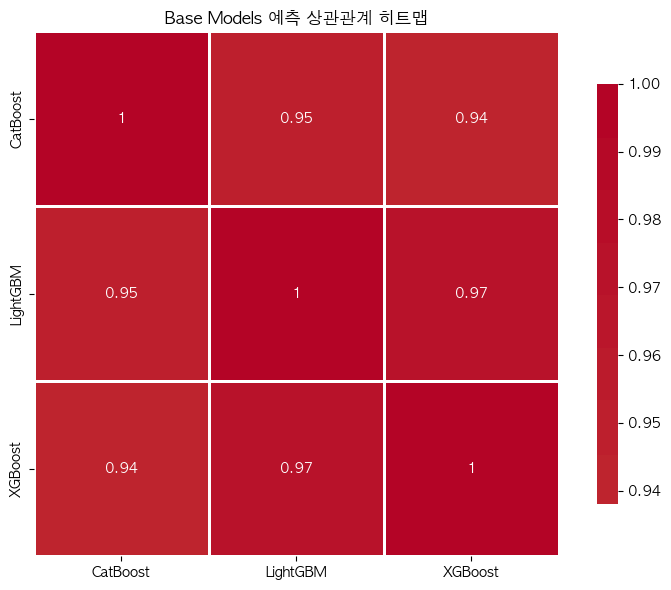


✅ 시각화 저장: ../output/figures/base_models_correlation.png


In [21]:
# Base Models 예측 상관관계 분석
oof_df = pd.DataFrame(oof_predictions)
correlation = oof_df.corr()

print(f"\n🔗 Base Models 예측 상관관계:")
display(correlation)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Base Models 예측 상관관계 히트맵')
plt.tight_layout()
plt.savefig('../output/figures/base_models_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 저장: ../output/figures/base_models_correlation.png")

## 5. Meta-Learner 학습

In [22]:
# Meta-Features 생성 (Base Models의 OOF 예측)
meta_features = pd.DataFrame(oof_predictions)

print(f"\n메타 피처 shape: {meta_features.shape}")
print(f"메타 피처 컬럼: {list(meta_features.columns)}")

# Meta-Learner 학습
print(f"\nMeta-Learner 학습 중...")
meta_learner.fit(meta_features, y)

# Meta-Learner OOF 예측
stacking_oof_pred = meta_learner.predict_proba(meta_features)[:, 1]
stacking_oof_auc = roc_auc_score(y, stacking_oof_pred)

print(f"\n🎯 Stacking OOF AUC: {stacking_oof_auc:.4f}")

# Meta-Learner 계수 확인
meta_coef = pd.DataFrame({
    'Base Model': meta_features.columns,
    'Coefficient': meta_learner.coef_[0],
    'Abs Coefficient': np.abs(meta_learner.coef_[0])
}).sort_values('Abs Coefficient', ascending=False)

print(f"\n📈 Meta-Learner 계수 (Base Model 기여도):")
display(meta_coef)


메타 피처 shape: (944767, 3)
메타 피처 컬럼: ['CatBoost', 'LightGBM', 'XGBoost']

Meta-Learner 학습 중...

🎯 Stacking OOF AUC: 0.6384

📈 Meta-Learner 계수 (Base Model 기여도):

🎯 Stacking OOF AUC: 0.6384

📈 Meta-Learner 계수 (Base Model 기여도):


,Base Model,Coefficient,Abs Coefficient
0,CatBoost,2.642600,2.642600
1,LightGBM,1.128667,1.128667
2,XGBoost,0.517583,0.517583


## 6. Stacking vs Base Models 비교

In [23]:
# 전체 성능 비교
comparison_results = base_results[['Model', 'Mean AUC']].copy()
comparison_results = pd.concat([
    comparison_results,
    pd.DataFrame({'Model': ['Stacking'], 'Mean AUC': [stacking_oof_auc]})
], ignore_index=True).sort_values('Mean AUC', ascending=False)

print(f"\n{'='*60}")
print("최종 성능 비교 (OOF AUC)")
print(f"{'='*60}")
display(comparison_results)

# 개선율 계산
best_base_auc = base_results['Mean AUC'].max()
improvement = (stacking_oof_auc - best_base_auc) / best_base_auc * 100

print(f"\n📊 Stacking 개선율:")
print(f"  최고 Base Model: {best_base_auc:.4f}")
print(f"  Stacking: {stacking_oof_auc:.4f}")
print(f"  개선율: {improvement:+.2f}%")


최종 성능 비교 (OOF AUC)


,Model,Mean AUC
3,Stacking,0.638448
0,CatBoost,0.637415
1,LightGBM,0.635893
2,XGBoost,0.634188



📊 Stacking 개선율:
  최고 Base Model: 0.6374
  Stacking: 0.6384
  개선율: +0.16%


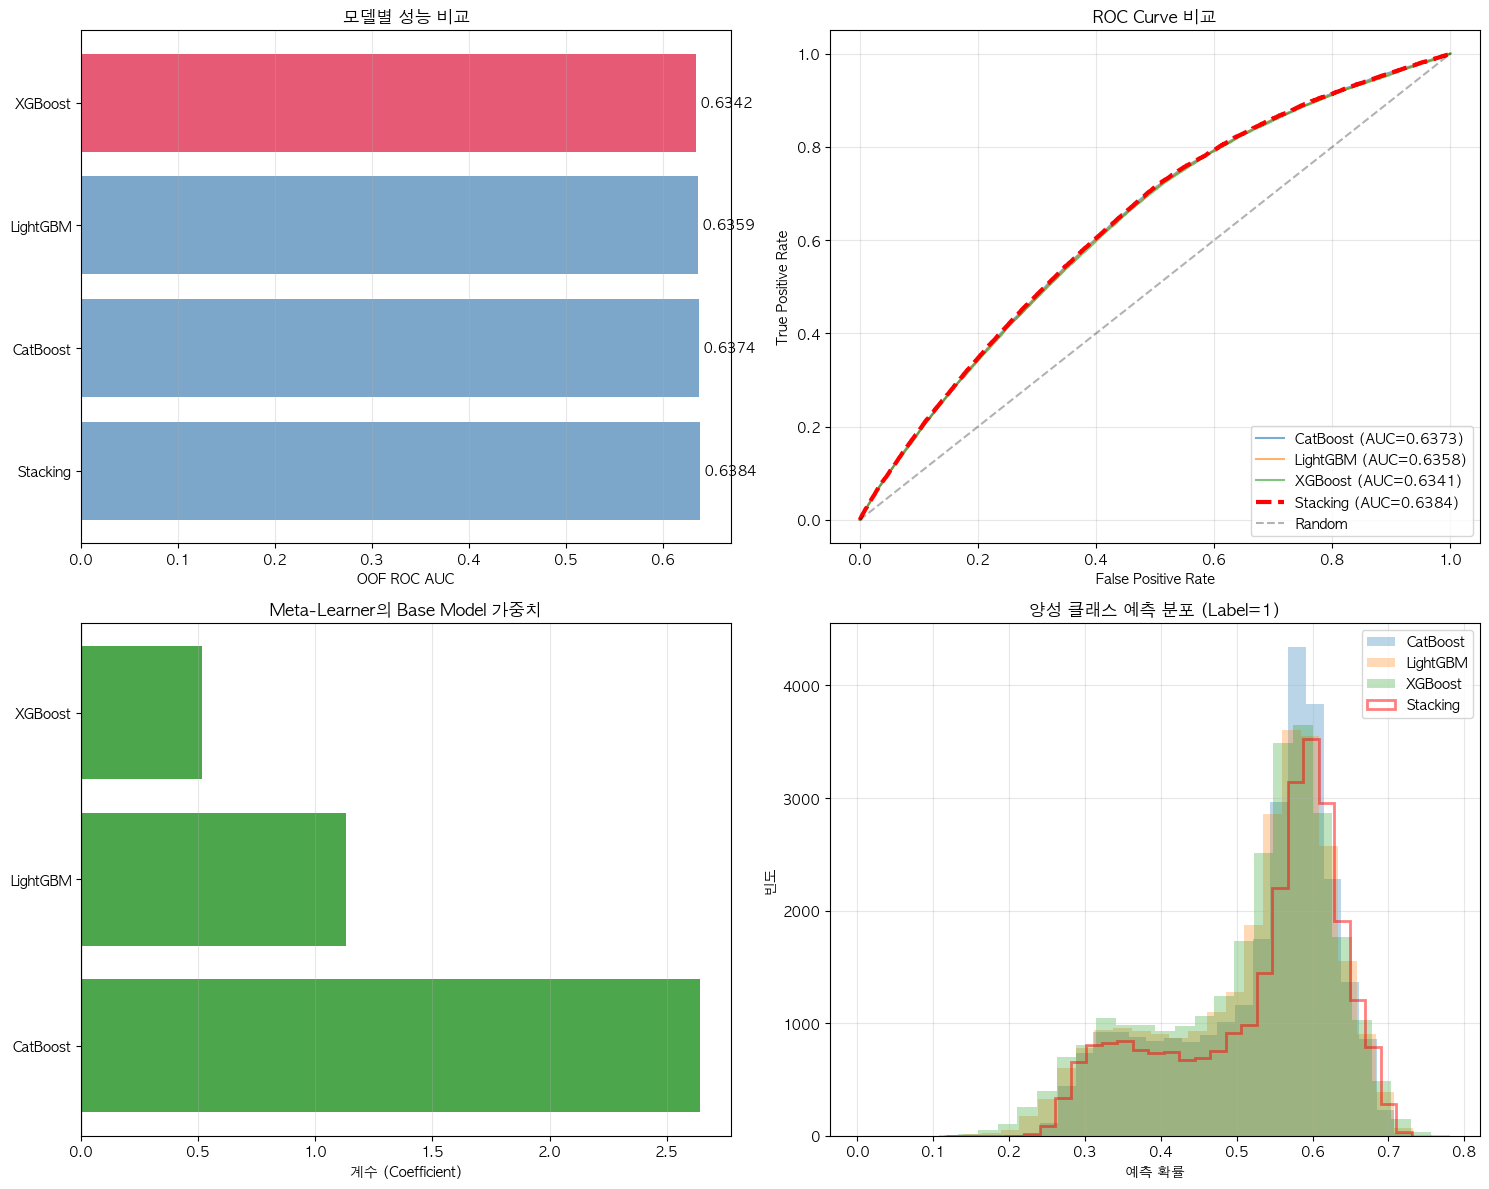


✅ 시각화 저장: ../output/figures/stacking_analysis.png


In [24]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 6-1. 모델별 성능 비교 막대 그래프
ax = axes[0, 0]
colors = ['steelblue'] * len(base_models) + ['crimson']
bars = ax.barh(comparison_results['Model'], comparison_results['Mean AUC'], color=colors, alpha=0.7)
ax.set_xlabel('OOF ROC AUC')
ax.set_title('모델별 성능 비교')
ax.grid(True, alpha=0.3, axis='x')

for i, (model, auc) in enumerate(zip(comparison_results['Model'], comparison_results['Mean AUC'])):
    ax.text(auc, i, f' {auc:.4f}', va='center', fontweight='bold')

# 6-2. ROC Curves 비교
ax = axes[0, 1]
for model_name, oof_pred in oof_predictions.items():
    fpr, tpr, _ = roc_curve(y, oof_pred)
    auc_score = roc_auc_score(y, oof_pred)
    ax.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.4f})", alpha=0.6)

# Stacking ROC
fpr, tpr, _ = roc_curve(y, stacking_oof_pred)
ax.plot(fpr, tpr, label=f"Stacking (AUC={stacking_oof_auc:.4f})", 
        linewidth=3, color='red', linestyle='--')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve 비교')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 6-3. Meta-Learner 계수
ax = axes[1, 0]
colors_coef = ['green' if c > 0 else 'red' for c in meta_coef['Coefficient']]
ax.barh(meta_coef['Base Model'], meta_coef['Coefficient'], color=colors_coef, alpha=0.7)
ax.set_xlabel('계수 (Coefficient)')
ax.set_title('Meta-Learner의 Base Model 가중치')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# 6-4. 예측 분포 비교
ax = axes[1, 1]
for model_name, oof_pred in oof_predictions.items():
    ax.hist(oof_pred[y==1], bins=30, alpha=0.3, label=model_name)
ax.hist(stacking_oof_pred[y==1], bins=30, alpha=0.5, label='Stacking', color='red', linewidth=2, histtype='step')
ax.set_xlabel('예측 확률')
ax.set_ylabel('빈도')
ax.set_title('양성 클래스 예측 분포 (Label=1)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/stacking_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 저장: ../output/figures/stacking_analysis.png")

## 7. 결과 저장

In [25]:
# Stacking 요약 저장
stacking_summary = pd.DataFrame({
    'Component': ['CatBoost (Base)', 'LightGBM (Base)', 'XGBoost (Base)', 'Stacking (Meta)'],
    'OOF_AUC': [
        roc_auc_score(y, oof_predictions['CatBoost']),
        roc_auc_score(y, oof_predictions['LightGBM']),
        roc_auc_score(y, oof_predictions['XGBoost']),
        stacking_oof_auc
    ],
    'Meta_Coefficient': list(meta_learner.coef_[0]) + [np.nan]
})

stacking_summary.to_csv('../output/stacking_summary.csv', index=False)
print("✅ Stacking 요약 저장: ../output/stacking_summary.csv")

# Meta-Learner 모델 저장
import pickle
with open('../output/models/meta_learner.pkl', 'wb') as f:
    pickle.dump(meta_learner, f)
print("✅ Meta-Learner 저장: ../output/models/meta_learner.pkl")

# OOF 예측 저장
stacking_oof_df = pd.DataFrame({
    'Test_id': train_features['Test_id'],
    'True_Label': y,
    'CatBoost_OOF': oof_predictions['CatBoost'],
    'LightGBM_OOF': oof_predictions['LightGBM'],
    'XGBoost_OOF': oof_predictions['XGBoost'],
    'Stacking_OOF': stacking_oof_pred
})

stacking_oof_df.to_csv('../output/stacking_oof_predictions.csv', index=False)
print("✅ Stacking OOF 예측 저장: ../output/stacking_oof_predictions.csv")

✅ Stacking 요약 저장: ../output/stacking_summary.csv
✅ Meta-Learner 저장: ../output/models/meta_learner.pkl
✅ Stacking OOF 예측 저장: ../output/stacking_oof_predictions.csv
✅ Stacking OOF 예측 저장: ../output/stacking_oof_predictions.csv


## 8. 인사이트 및 결론

### 주요 발견
1. **Ensemble 효과**: 여러 모델의 강점을 결합하여 단일 모델 대비 안정적인 성능
2. **모델 다양성**: Base Models 간 낮은 상관관계가 Stacking 효과를 극대화
3. **Meta-Learner 역할**: 각 Base Model의 강점을 학습하여 최적 조합 발견

### Base Models 특성
- **CatBoost**: 카테고리 변수 처리 우수, 안정적 성능
- **LightGBM**: 빠른 학습 속도, 메모리 효율적
- **XGBoost**: 강력한 일반화 성능, 과적합 방지

### Stacking 장점
- 단일 모델의 편향(bias) 감소
- 예측 분산(variance) 감소로 안정성 향상
- 각 모델의 오류를 상호 보완

### 다음 단계
- Test 데이터에 Stacking 적용
- Base Models 하이퍼파라미터 튜닝
- 더 많은 Base Models 추가 실험 (RandomForest, Neural Network 등)